# Learning Liar's dice with deep Q-learning

<ins>Author:</ins> Alexandre Forestier--Foray  (https://github.com/Aff54)  
<ins>Date:</ins> 22/01/2026

<ins>Note:</ins>
- For simplicity, examples are shown with 3 players and 2 dice per player by default. It is possible to increase these numbers but be aware that more players/dice can increase computation time significantly.

In [1]:
# ---- Regular Packages ----
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os
from collections import namedtuple
import pandas as pd
import math

# Reinforcement learning.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# ---- Custom packages ----

from src.reinforcement_learning import ReplayMemory
from src.probability_analysis import plot_situation
from src.action_management import get_legal_actions_mask, get_possible_actions
from src.deterministic_agents import agent_random, agent_max_probability, agent_min_probability
from src.rl_agents import RLAgent
from src.game import GameRL
from src.performance_analysis.analysis_tools import test_agents, get_player_score
from src.performance_analysis.visual_tools import plot_pie_charts
from src.rl_agents import RLAgentOnline, EpsilonScheduler

C:\Users\alexa\Documents\Python Scripts\Perudo\src\rl_agents.py:161: SyntaxWarning: invalid escape sequence '\ '
  """Pushes a transition into the agent's memory.


In [3]:
# GPU usage.
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print(f"used divice: {device}")

used divice: cuda


# 1. Liar's dice game class

<ins>Note:</ins>
- The Game class implements the core mechanics of Liar’s Dice. It is responsible for managing player hands, turn order and player interactions (calling "liar" or "exact"). It provides an interface for simulating a game.
- GameRL subclass extends Game by adding reinforcement learning-specific methods, such as state representation or game set-up.

In [ ]:
# ---- Game initialisation ----

game = GameRL(player_number = 3, max_dice = 2)
game.summerize()

In [ ]:
# getting turn info

n_dice, last_bet, turn_player, turn_player_hand = game.get_turn_info()

print(f"Turn player: {turn_player}\n"
      f"Turn player hand: {turn_player_hand}\n"
      f"Last bet: {last_bet}")

<ins>Note:</ins> by default, the game starts with $last\_bet = [1, 0]$

In [ ]:
# ---- Playing from a player's perspective ----

# insert your action here. Format: [quantity, value]
# calling "liar":[-1, -1] / "exact": [0, 0]
action = [2, 2]

game.make_a_bet(action, verbose = True)

# getting turn info
n_dice, last_bet, turn_player, turn_player_hand = game.get_turn_info()

print(f"turn player: {turn_player}\n"
      f"turn player hand: {turn_player_hand}\n"
      f"last bet: {last_bet}")

<ins>Note:</ins> The Game class does not enforce bet legality. Instead, a legal action generator was incorporated to the agent implementations (deterministic or probabilistic), which filter the action space to ensure that only valid actions are selected. As a result, all agents used in this project are guaranteed to return legal actions.

# 2. Deterministic agent functions

<ins>Note:</ins> In order to represent three types of player, for the rl agent to play against, we defined three distinct policies:
- A "survivalist" policy that maximizes survival: each turn, this agent selects the action (calling "liar", "exact" or outbidding) with the highest probability of being true. In case of equal probabilities, the most aggressive action (i.e. with highest quantity and/or value ) is chosen.
- An "aggressive" policy: each turn, selects the action with the lowest probability of being true among those whose probability exceeds a predefined threshold (50% by default). This policy favors high quantity/value bets while maintaining a minimum survival probability.
- A "random" policy: each turn, returns a random (from uniform distribution) action among legal actions.

Action probabilities are computed using a binomial distribution conditioned on the player’s hand.

## 2.1. Visual example

The following cell displays the probability of each outbid to be true condition to the turn player hand.

In [ ]:
# ---- Displaying deterministic agent's perspective ----

# insert total number of dice in game.
n_dice = 6

# insert last_bet for the agent to play after. Format: [quantity, value].
last_bet = [1, 6]

# insert player hand. Format: [d_1, d_2, ...] with d_i in {1,..., 6}.
turn_player_hand = [2, 3]

plot_situation(total_dice = n_dice,
               player_hand = turn_player_hand, 
               last_bet = last_bet)

# insert deterministic agent function among { agent_random, agent_max_probability, agent_min_probability }.
policy_function = agent_max_probability

# action selection.
action = policy_function(last_bet = last_bet, 
                         total_dice = n_dice,
                         player_hand = turn_player_hand,
                         verbose = True)

## 2.2. Example of strategies playing together.

Use the following cells for making deterministic agent play together. You can add or remove players from players_dict 
or modify the number of dice players start with.

In [ ]:
# ---- Game set-up ----

# dict used for storing player functions. 
players_dict = {1: agent_max_probability, 2: agent_min_probability, 3: agent_random}

# game parameters
player_number = len(players_dict)
max_dice = 2

In [ ]:
# ---- Game loop ----

# Game instantiation
game = GameRL(player_number = player_number,
              max_dice = max_dice)
game.summerize()

print("---- Game starts ----")
# Playing the game
while not game.game_over:

    n_dice, last_bet, turn_player, turn_player_hand = game.get_turn_info()

    # Action selection by deterministic agent.
    print(f"player {turn_player} is playing with hand {turn_player_hand}")
    action = players_dict[turn_player](last_bet = last_bet, 
                                       total_dice = n_dice,
                                       player_hand = turn_player_hand,
                                       verbose = True)

    # Taking action.
    bet_outcome = game.make_a_bet(bet = action,
                                  verbose = True)

ranking = game.ranking
print(f"player {ranking[0]} won \n"
      f"---- Game ends ----")

## 2.3 Simulating multiple games

Use the following cells for simulating games with deterministic agents and plot their overall ranking.

In [ ]:
# ---- Game set-up ----

# dict used for storing player functions
players_dict = {1: agent_max_probability, 2: agent_min_probability, 3: agent_random}

# game parameters
player_number = len(players_dict)
max_dice = 2

# simulation parameters
n_simulation = 1000

In [ ]:
# ---- Simulating games ----

rankings = np.zeros((n_simulation, player_number))

for i in tqdm(range(n_simulation), desc = "Simulation"):

    # Initialisation.
    game = GameRL(player_number = player_number, 
                  max_dice = max_dice)

    # Playing the game
    while not game.game_over:
    
        n_dice, last_bet, turn_player, turn_player_hand = game.get_turn_info()
    
        # Action selection by deterministic agent.
        action = players_dict[turn_player](last_bet = last_bet, 
                                           total_dice = n_dice,
                                           player_hand = turn_player_hand,
                                           verbose = False)
    
        # Taking action.
        bet_outcome = game.make_a_bet(bet = action,
                                      verbose = False)

    # Saving game results
    rankings[i, :] = game._ranking

In [ ]:
# ---- Plotting place distribution ----
_ = plot_pie_charts(rankings)

# 3. Reinforcement learning

<ins>Note:</ins>
- The training loop is an adaptation of PyTorch's RL tutorial (see https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html);
- The algorithm used for training the agent is DDQN (double DQN);
- The rl agent is implemented with the RLAgentOnline class. This class stores transitions
the agent is going through in a memory buffer.

## 3.1 Training an agent with DDQN

<ins>Note:</ins> In DQN, the network takes the current state as input and outputs a Q-value for **each action**, including illegal ones, as a vector of size (action_number). Thus, we:
- encoded actions as integers to index the corresponding network outputs;
- applied an action mask to prevent the agent from selecting illegal actions.

In [12]:
# ---- Simulation parameters ----

# -- Game parameters --
max_dice = 2
player_number = 3
transition_format = ('state', 'action', 'next_state', 'reward', 'legal_actions_mask', 'game_index')
Transition = namedtuple('Transition',
                        transition_format)

# Getting matching between actions and their index.
game = GameRL(player_number = player_number,
                       max_dice = max_dice)

action_dict = game.get_action_dict()
reverse_action_dict = {v: k for k, v in action_dict.items()}
# The Q-network input size corresponds to states length.
n_states = game.get_n_states()
# The Q-network output size is the number of every possible action
n_actions = game.get_n_actions()

# -- Deep learning parameters --
batch_size = 256
learning_rate = 3e-3
criterion = nn.SmoothL1Loss()
metric = nn.L1Loss()
weight_decay_rate = 0 # 1e-2

# -- RL parameters --
# reward format: 
# 0: current player called liar and was right.
# -1: current player called liar or exact and was wrong or his bet was challenged and was wrong.
# 1: current player called exact and was right. He earned a dice back.
# 2: current player outbids
# 3: current player won current game
# 4: current player outbid, was challenged on and challenger lost a dice
# 5: current player made an easy bet, following player called "exact" and earned a dice back.
# 6: round ended without player losing or earning a dice
reward_dict = {0: 1, 
               -1: -2,
               1: 2, 
               2: 0, 
               3: 10,
               4: 1, 
               5: -0.5,
               6: 0} 

n_training_game = 4000
n_test_game = 1000
warm_up_duration = 300
gamma = 1
tau = 0.001
eps_max = 1
eps_min = 0.2
epsilon_scheduler_rate = 1e4/ (3*math.log(10))
optimization_inter_step = 10

memory_capacity = 5000
memory = ReplayMemory(transitions_tuple = Transition, capacity = memory_capacity)

In [13]:
# ---- DQN class ----
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, hidden_layer_size = 64):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, hidden_layer_size)
        self.layer2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.layer3 = nn.Linear(hidden_layer_size, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

<ins>Note:</ins> The Q-network architecture used in this project is intentionally simple. More complex architectures could be explored to potentially improve performance.

In [14]:
def optimize_model(memory, 
                   criterion = nn.SmoothL1Loss(), 
                   metric = nn.L1Loss(), 
                   batch_size = batch_size, 
                   gamma = gamma):
    
    if len(memory) < batch_size:
        return None, None, None

    # -- Randomly sample dataset --
    transitions = memory.sample(batch_size = batch_size)
    # Convert batch-array of transitions into transition of batch-array.
    batch = Transition(*zip(*transitions))

    # Making masks for final states. 
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, 
                                            batch.next_state)), 
                                  device=device, 
                                  dtype=torch.bool)
    non_final_next_states = torch.as_tensor([s 
                                             for s in batch.next_state 
                                             if s is not None], 
                                            dtype=torch.float32).to(device)

    # Separating states / actions / rewards / legal action masks
    state_batch = torch.as_tensor(batch.state, dtype=torch.float32, device=device)
    action_batch = torch.as_tensor(batch.action, dtype=torch.long, device=device)
    reward_batch = torch.as_tensor(batch.reward, dtype=torch.float32, device=device)
    legal_action_batch = torch.from_numpy(np.stack(batch.legal_actions_mask)).to(device)

    # Predicting action Q-values and keeping actions 
    # that were actually done during simulation.
    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
    
    next_state_values = torch.zeros(batch_size, device=device)
    # Keeping non final state Q value.
    with torch.no_grad():
        next_actions = policy_net(non_final_next_states)

    # Putting illegal action values to -1e9
    legal_mask = legal_action_batch[non_final_mask]
    next_actions[~legal_mask] = -1e9
    best_next_actions = next_actions.argmax(dim=1, keepdim=True)
        
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, best_next_actions).squeeze(1)

    # Right side of Bellman's equation : r + gamma*max_a(Q_target(s', a))
    expected_state_action_values = reward_batch + (next_state_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1)

    # Compute Huber loss
    loss = criterion(state_action_values, expected_state_action_values)

    # Computing metric
    metric_value = metric(state_action_values, expected_state_action_values).item()

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    # training data
    loss_value = loss.item()
    avg_prediction_value = state_action_values.mean().detach().cpu().item()

    return loss_value, avg_prediction_value, loss_value/avg_prediction_value, metric_value

In [15]:
# ---- Player definition ----

rl_agent = RLAgentOnline(n_states = n_states, 
                         n_actions = n_actions, 
                         action_dict = action_dict, 
                         reward_dict = reward_dict,
                         reverse_action_dict = reverse_action_dict,
                         transitions_tuple = Transition,
                         memory_capacity = memory_capacity,
                         DQN_class = DQN)

players_dict = {1: agent_max_probability, 2: agent_min_probability, 3: rl_agent}
epsilon_rate_scheduler = EpsilonScheduler(eps_max = eps_max, 
                                         eps_min = eps_min, 
                                         tau = epsilon_scheduler_rate)

# -- Safeguard --
# Verify if there are as many players as planned + if there is exactly one RLAgentOnline instance.
if len(players_dict) != player_number:
    raise ValueError(f"players_dict has not the same amount of players than given by player_number: players_dict length: {len(players_dict)} VS {player_number}")
rl_agent_index_list = [index for index, agent in players_dict.items() if isinstance(agent, RLAgentOnline)]
if len(rl_agent_index_list) != 1:
    raise ValueError(f"The number of rl agents in players_dict is incorrect")
else:
    rl_agent_index = rl_agent_index_list[0]

<ins>Note:</ins> Playing games for filling the rl agent's memory buffer.

In [16]:
# ---- Warm-up ----
epsilon = epsilon_rate_scheduler.get_epsilon()

# Initialize the networks
policy_net = DQN(n_states, n_actions).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr=learning_rate, amsgrad=True, weight_decay = weight_decay_rate)
target_net = DQN(n_states, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# -- Warm-up --
game_index = 0

for i in tqdm(range(warm_up_duration), desc = "warming-up", disable = False):
    # Initialising game.
    game = GameRL(player_number = player_number,
                  max_dice = max_dice)
    game_index += 1
    while not game.game_over:
        
        n_dice, last_bet, turn_player, turn_player_hand = game.get_turn_info()
        last_player = game.active_players[-1]
        state = game.get_state()
        
        # Seperating deterministic functions VS RL agents
        if isinstance(players_dict[turn_player], RLAgentOnline): # player_object is an Agent class instance.

            action = players_dict[turn_player].epsilon_greedy_select_action(last_bet = last_bet, 
                                                                            total_dice = n_dice,
                                                                            state = state, 
                                                                            epsilon = epsilon,
                                                                            game_index = game_index,
                                                                            verbose = False)
            # Taking action.
            bet_outcome = game.make_a_bet(action,
                                          verbose = False)

            players_dict[turn_player].receive_outcome(bet_outcome, 
                                                      game_index = game_index)

        else: # player_object is a deterministic function.
            action = players_dict[turn_player](last_bet = last_bet,
                                               total_dice = n_dice,
                                               player_hand = turn_player_hand,
                                               verbose = False)
            # Taking action.
            bet_outcome = game.make_a_bet(action, 
                                          verbose = False)

            # Current bet is a challenge
            if bet_outcome != 2:
                
                # Last player was the rl_agent
                if isinstance(players_dict[last_player], RLAgentOnline):
                    
                    # Current player called tracked player "liar" and was right
                    if bet_outcome == 0:
                        agent_outcome = -1
                        # Current player called tracked player "liar" or "exact" and was wrong
                    elif bet_outcome == -1:
                        agent_outcome = 4
                    # Current player called exact "exact" and was right 
                    # => punishment for a bet too easy to predict but less important than loosing a dice.
                    elif bet_outcome == 1:
                        agent_outcome = 5

                    players_dict[last_player].receive_outcome(agent_outcome, 
                                                          game_index = game_index)

                # Last player was not the rl_agent
                else:
                    # rl_agent is still active.
                    if last_player in game.active_players:
                        agent_outcome = 6
                    
                        players_dict[rl_agent_index].receive_outcome(agent_outcome, 
                                                        game_index = game_index)

warming-up: 100%|████████████████████████████████████████████████████████████████████| 300/300 [00:34<00:00,  8.70it/s]


In [ ]:
# ---- Training ----

# metrics
first_place_rate_list = []
average_place_list = []
train_loss_list = []
avg_prediction_value_list = []
train_metric_list = []

for i in tqdm(range(n_training_game + 1), desc = "online_training", disable = False):
    # Initialising game.
    game = GameRL(player_number = player_number,
                  max_dice = max_dice)
    game_index += 1

    # -- testing network --
    if i % 1000 == 0:
        rankings, _ = test_agents(max_dice = max_dice, 
                                players_dict = players_dict, 
                                n_simulation = n_test_game, 
                                reward_dict = reward_dict, 
                                RLAgent_class = RLAgentOnline,
                                tqdm_display = False, 
                                verbose = False)
        
        first_place_rate = np.count_nonzero(rankings[:, 0] == rl_agent_index)/len(rankings)
        average_place = get_player_score(rankings, rl_agent_index)
        print(f"Agent's first place rate: {first_place_rate * 100 :.2f} % / average place: {average_place}")

        # saving testing metrics
        first_place_rate_list.append(first_place_rate)
        average_place_list.append(average_place)
    
    while not game.game_over:
        
        # -- Playing the game --
        n_dice, last_bet, turn_player, turn_player_hand = game.get_turn_info()
        last_player = game.active_players[-1]
        state = game.get_state()
        
        # Seperating deterministic functions VS RL agents
        if isinstance(players_dict[turn_player], RLAgentOnline): # player_object is an Agent class instance.

            epsilon = epsilon_rate_scheduler.get_epsilon()
            action = players_dict[turn_player].epsilon_greedy_select_action(last_bet = last_bet, 
                                                                            total_dice = n_dice,
                                                                            state = state, 
                                                                            epsilon = epsilon,
                                                                            game_index = game_index,
                                                                            verbose = False)
            # Taking action.
            bet_outcome = game.make_a_bet(action,
                                          verbose = False)

            players_dict[turn_player].receive_outcome(bet_outcome, 
                                                      game_index = game_index)

            epsilon_rate_scheduler.step()

            # -- Training network --
            if epsilon_rate_scheduler.step_count % optimization_inter_step == 0:

                training_step = epsilon_rate_scheduler.step_count
                train_loss, avg_prediction_value, loss_avg_prediction_value_rate, metric_value = optimize_model(memory = rl_agent.memory)
            
                # Updating weights
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)
                target_net.load_state_dict(target_net_state_dict)
                rl_agent.policy_network.load_state_dict(policy_net.state_dict())

                # Log training metrics at each step
                train_loss_list.append(train_loss)
                avg_prediction_value_list.append(avg_prediction_value)
                train_metric_list.append(metric_value)
                
        
        else: # player_object is a deterministic function.
            action = players_dict[turn_player](last_bet = last_bet,
                                   total_dice = n_dice,
                                   player_hand = turn_player_hand,
                                   verbose = False)
            # Taking action.
            bet_outcome = game.make_a_bet(action, 
                                          verbose = False)

            # Current bet is a challenge
            if bet_outcome != 2:
                
                # Last player was the rl_agent
                if isinstance(players_dict[last_player], RLAgentOnline):
                    
                    # Current player called tracked player "liar" and was right
                    if bet_outcome == 0:
                        agent_outcome = -1
                        # Current player called tracked player "liar" or "exact" and was wrong
                    elif bet_outcome == -1:
                        agent_outcome = 4
                    # Current player called exact "exact" and was right 
                    # => punishment for a bet too easy to predict but less important than loosing a dice.
                    elif bet_outcome == 1:
                        agent_outcome = 5

                    players_dict[last_player].receive_outcome(agent_outcome, 
                                                          game_index = game_index)

                # Last player was not the rl_agent
                else:
                    # rl_agent is still active.
                    if last_player in game.active_players:
                        agent_outcome = 6
                    
                        players_dict[rl_agent_index].receive_outcome(agent_outcome, 
                                                        game_index = game_index)

        # Ending game faster if rl agent lost
        if rl_agent_index not in game.active_players:
            break

    
# -- Plotting last rankings array as pie chart --
_ = plot_pie_charts(rankings)

online_training:   0%|                                                             | 3/4001 [01:56<33:29:24, 30.16s/it]

Agent's first place rate: 0.40 % / average place: 2.759


online_training:  25%|██████████████▌                                           | 1001/4001 [06:28<33:49:10, 40.58s/it]

Agent's first place rate: 63.10 % / average place: 1.656


online_training:  50%|█████████████████████████████                             | 2001/4001 [11:15<19:50:27, 35.71s/it]

Agent's first place rate: 73.70 % / average place: 1.498


online_training:  75%|█████████████████████████████████████████████▋               | 3000/4001 [13:29<02:16,  7.33it/s]

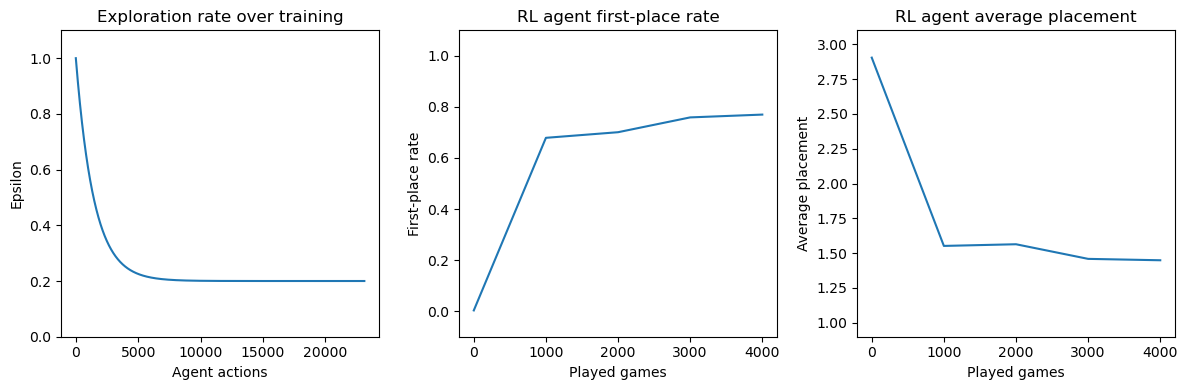

In [10]:
# ---- Plotting agent's performance ----
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# -- epsilon over environment steps --
ax[0].plot(epsilon_rate_scheduler.epsilon_history)
ax[0].set_xlabel("Agent actions")
ax[0].set_ylabel("Epsilon")
ax[0].set_title("Exploration rate over training")
ax[0].set_ylim(0, 1.1)

# -- first-place rate over training --
ax[1].plot(np.arange(0, len(first_place_rate_list)*1000, 1000), first_place_rate_list)
ax[1].set_xlabel("Played games")
ax[1].set_ylabel("First-place rate")
ax[1].set_title("RL agent first-place rate")
ax[1].set_ylim(-0.1, 1.1)

# -- average placement over training --
ax[2].plot(np.arange(0, len(average_place_list)*1000, 1000), average_place_list)
ax[2].set_xlabel("Played games")
ax[2].set_ylabel("Average placement")
ax[2].set_title("RL agent average placement")
ax[2].set_ylim(0.9, player_number + 0.1)

fig.tight_layout()

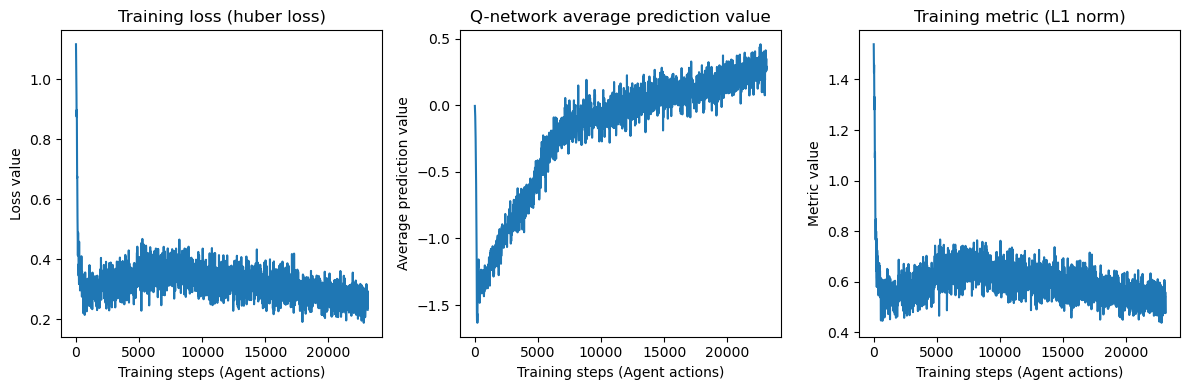

In [11]:
# ---- Plotting agent's performance ----
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# -- epsilon over environment steps --
ax[0].plot(np.arange(0, len(train_loss_list)*10, 10), train_loss_list)
ax[0].set_xlabel("Training steps (Agent actions)")
ax[0].set_ylabel("Loss value")
ax[0].set_title("Training loss (huber loss)")

# -- first-place rate over training --
ax[1].plot(np.arange(0, len(avg_prediction_value_list)*10, 10), avg_prediction_value_list)
ax[1].set_xlabel("Training steps (Agent actions)")
ax[1].set_ylabel("Average prediction value")
ax[1].set_title("Q-network average prediction value")

# -- average placement over training --
ax[2].plot(np.arange(0, len(train_metric_list)*10, 10), train_metric_list)
ax[2].set_xlabel("Training steps (Agent actions)")
ax[2].set_ylabel("Metric value")
ax[2].set_title("Training metric (L1 norm)")

fig.tight_layout()

## 3.2 Making RL agent play

In [ ]:
# ---- Game loop ----

# Game instantiation
game = GameRL(player_number = player_number,
              max_dice = max_dice)
game.summerize()

print("---- Game starts ----")
# Playing the game
while not game.game_over:

    n_dice, last_bet, turn_player, turn_player_hand = game.get_turn_info()

    # Action selection by deterministic agent.
    print(f"player {turn_player} is playing with hand {turn_player_hand}")

    # Seperating deterministic functions VS RL agents
    if isinstance(players_dict[turn_player], RLAgentOnline): # player_object is an Agent class instance.

        state = game.get_state()
        action = players_dict[turn_player].select_action(last_bet = last_bet, 
                                                         total_dice = n_dice, 
                                                         state = state)
        print(f"RL agent plays {action}")

    else:
                    
        action = players_dict[turn_player](last_bet = last_bet, 
                                           total_dice = n_dice,
                                           player_hand = turn_player_hand,
                                           verbose = True)

    # Taking action.
    bet_outcome = game.make_a_bet(bet = action,
                                  verbose = True)

ranking = game.ranking
print(f"player {ranking[0]} won \n"
      f"---- Game ends ----")